# 5章 GLMの尤度比検定と検定の非対称性

[HOME](https://whatalnk.github.io/stat-model-intro)

スクリプト: [Chap05.r](https://raw.githubusercontent.com/whatalnk/stat-model-intro/master/Chap05.r)



* 尤度比検定
    * 逸脱度の差に注目
    * ネストしているモデルたちを比較できる
* パラメトリック
* ノンパラメトリック

## 5.1 統計学的な検定のわくぐみ

__Neyman-Pearsonの検定のわくぐみ__（AICによるモデル選択との比較，図5.1）

1. 使用するデータを決める
1. 適切な統計モデルの設定，パラメータの最尤推定
    * 帰無仮説と対立仮設
1. 帰無仮説棄却の危険率を評価
    * 検定統計量を決める
    * 帰無仮説が成り立つと仮定した場合の検定統計量の値が発生しても珍しくない範囲を定める（95%なら有意水準5%）
1. 帰無仮説が棄却できるかを判定    

## 5.2 尤度比検定の例題: 逸脱度の差を調べる

* 3章データ（種子数）
* 平均が $\lambda = \exp(\beta_1 + \beta_2 x_i)$ のポアソン分布のGLM
* 一定モデルとxモデルを比較，一定モデルが棄却できるかどうかを調べる


In [ ]:
if (interactive()) {
    (function(x){
        notinstalled <- x[!(x %in% installed.packages()[, "Package"])]
        if (length(notinstalled) > 0) {
            cat(sprintf("Install %d packages: %s \n", length(notinstalled), notinstalled))
            install.packages(notinstalled)
        } else {
            cat("Already installed\n")
           installed.packages()[, "Version"][x] 
        }
    })(c("pipeR", "dplyr", "tidyr", "ggplot2", "readr", "knitr", "devtools"))
}

In [1]:
sapply(c("pipeR", "dplyr", "tidyr", "ggplot2", "readr"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE

In [2]:
d <- read_csv("data/chap03/data3a.csv")
str(d)

Parsed with column specification:
cols(
  y = col_integer(),
  x = col_double(),
  f = col_character()
)


Classes 'tbl_df', 'tbl' and 'data.frame':	100 obs. of  3 variables:
 $ y: int  6 6 6 12 10 4 9 9 9 11 ...
 $ x: num  8.31 9.44 9.5 9.07 10.16 ...
 $ f: chr  "C" "C" "C" "C" ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 3
  .. ..$ y: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ x: list()
  .. .. ..- attr(*, "class")= chr  "collector_double" "collector"
  .. ..$ f: list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


一定モデル

In [3]:
fit.null <- glm(y ~ 1, data = d, family = "poisson")
fit.null


Call:  glm(formula = y ~ 1, family = "poisson", data = d)

Coefficients:
(Intercept)  
      2.058  

Degrees of Freedom: 99 Total (i.e. Null);  99 Residual
Null Deviance:	    89.51 
Residual Deviance: 89.51 	AIC: 477.3

In [4]:
logLik(fit.null)

'log Lik.' -237.6432 (df=1)

xモデル

In [5]:
fit.x <- glm(y ~ x, data = d, family = "poisson")
fit.x


Call:  glm(formula = y ~ x, family = "poisson", data = d)

Coefficients:
(Intercept)            x  
    1.29172      0.07566  

Degrees of Freedom: 99 Total (i.e. Null);  98 Residual
Null Deviance:	    89.51 
Residual Deviance: 84.99 	AIC: 474.8

In [6]:
logLik(fit.x)

'log Lik.' -235.3863 (df=2)

フルモデルの最大対数尤度，逸脱度，AIC

In [7]:
fit.full <- list()
fit.full$maxLogLik <- dpois(d$y, lambda = d$y) %>>% log() %>>% sum()
fit.full$dev <- -2 * fit.full$maxLogLik
fit.full$aic <- -2 * (fit.full$maxLogLik - length(d$y))
fit.full

$maxLogLik
[1] -192.8898

$dev
[1] 385.7795

$aic
[1] 585.7795

In [8]:
options(repr.plot.width = 4, repr.plot.height = 4)

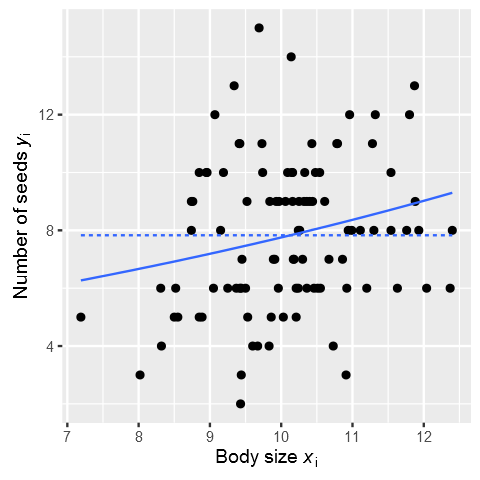

In [9]:
ggplot(aes(x = x, y = y), data = d) + 
    geom_point() + 
    stat_smooth(formula = y ~ 1, method="glm", method.args = list(family = "poisson"), se = FALSE, size = 0.5, linetype = "dashed") + 
    stat_smooth(formula = y ~ x, method="glm", method.args = list(family = "poisson"), se = FALSE, size = 0.5) + 
    xlab(expression("Body size"~italic(x)[i])) + 
    ylab(expression("Number of seeds"~italic(y)[i]))

In [10]:
data.frame(
    "model" = c("Null", "x", "Full"), 
    "k" = c(1, 2, 100), 
    "max.log.L" = c(logLik(fit.null), logLik(fit.x), fit.full$maxLogLik), 
    "deviance" = c(fit.null$deviance, fit.x$deviance, 0) + fit.full$dev, 
    "resd.dev." = c(fit.null$deviance, fit.x$deviance, 0), 
    "aic" = c(fit.null$aic, fit.x$aic, fit.full$aic)
) %>>% mutate_each(funs(round(., 1)), max.log.L:aic) %>>% knitr::kable()



|model |   k| max.log.L| deviance| resd.dev.|   aic|
|:-----|---:|---------:|--------:|---------:|-----:|
|Null  |   1|    -237.6|    475.3|      89.5| 477.3|
|x     |   2|    -235.4|    470.8|      85.0| 474.8|
|Full  | 100|    -192.9|    385.8|       0.0| 585.8|

尤度比: 

$$\frac{L_1^\ast}{L_2^\ast} = \frac{\text{Max. likelyhood of Null model}}{\text{Max. likelyhood of x model}}$$

尤度比検定の検定統計量: 逸脱度の差（尤度比の対数 × -2）

$$\Delta D_{1, 2} = -2 \times (\log L_1^\ast - \log L_2^\ast)$$

例題の場合だと，約4.5の改善

In [11]:
(fit.null$deviance - fit.x$deviance)

[1] 4.513941

## 5.3 2種類の過誤と統計学的な検定の非対称性
統計学的な検定
* 帰無仮説: Null model
* 対立仮設: x model

2種類の過誤
* Type I error: 真のモデルは Null model なのに 観測データが Null model からではなく x model から生じたと判断する（帰無仮説を棄却）
* Type II error: 真のモデルはNull model ではないのに，観測データが Null model から生じたと判断する（帰無仮説を棄却できない）

Type I error を検討
1. 帰無仮説が正しいとする（$\hat{\beta}_1 = 2.06$ を得る）
1. $\hat{\beta}_1 = 2.06$ のモデルからいくつもデータを生成して，$\Delta D_{1,2}$ の分布を得る
1. $\Delta D_{1,2} \ge 4.5$ なる確率 $P$ を計算する
1. $P$ を検討

## 5.4 帰無仮説を棄却するための有意水準

有意水準$\alpha$を設定しておいて，

* $P \ge \alpha$: 帰無仮説を棄却できない
* $P \lt \alpha$: 帰無仮説を棄却

とする（$\alpha = 0.05$ が多い）．

以下では2種類の方法で$P$値を計算する 

### 5.4.1 方法（1）汎用性のあるパラメトリックブートストラップ法

1. 平均 `mean(d$y)` のポアソン乱数を生成
    * Null model で推定した平均種子数: $\exp(\beta_1)$
1. 生成した乱数から $\Delta D_{1,2}$ を計算

In [12]:
readLines("Data/chap05/pbnew.R", encoding = "UTF-8") %>>% cat(sep="\n")

get.dd <- function(d) # データの生成と逸脱度差の評価
{
  n.sample <- nrow(d) # データ数
  y.mean <- mean(d$y) # 標本平均
  d$y.rnd <- rpois(n.sample, lambda = y.mean)
  fit1 <- glm(y.rnd ~ 1, data = d, family = poisson)
  fit2 <- glm(y.rnd ~ x, data = d, family = poisson)
  fit1$deviance - fit2$deviance # 逸脱度の差を返す
}

pb <- function(d, n.bootstrap)
{
  replicate(n.bootstrap, get.dd(d))
}


In [13]:
readLines("Data/chap05/pb.R", encoding = "UTF-8") %>>% cat(sep="\n")

pb <- function(d, n.bootstrap)
{
	n.sample <- nrow(d)
	y.mean <- mean(d$y)
	cat("# ")
	v.d.dev12 <- sapply(
		1:n.bootstrap,
		function(i) {
			cat(".")
			if (i %% 50 == 0) cat("\n# ")
			d$y.rnd <- rpois(n.sample, lambda = y.mean)
			fit1 <- glm(y.rnd ~ 1, data = d, family = poisson)
			fit2 <- glm(y.rnd ~ x, data = d, family = poisson)
			fit1$deviance - fit2$deviance
		}
	)
	cat("\n")
	v.d.dev12
}


In [14]:
source("Data/chap05/pb.R")
# or
# source("http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/lrtest/pb.R")
pb

function (d, n.bootstrap) 
{
    n.sample <- nrow(d)
    y.mean <- mean(d$y)
    cat("# ")
    v.d.dev12 <- sapply(1:n.bootstrap, function(i) {
        cat(".")
        if (i%%50 == 0) 
            cat("\n# ")
        d$y.rnd <- rpois(n.sample, lambda = y.mean)
        fit1 <- glm(y.rnd ~ 1, data = d, family = poisson)
        fit2 <- glm(y.rnd ~ x, data = d, family = poisson)
        fit1$deviance - fit2$deviance
    })
    cat("\n")
    v.d.dev12
}

In [15]:
dd12 <- pb(d, n.bootstrap = 1000)

# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ............................................

In [30]:
dd12.x <- pb(d, n.bootstrap = 10000)

# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ..................................................
# ............................................

In [16]:
summary(dd12)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000002  0.099430  0.421100  1.002000  1.309000 12.690000 

In [17]:
options(repr.plot.width = 4, repr.plot.height = 4)

$10^3$回

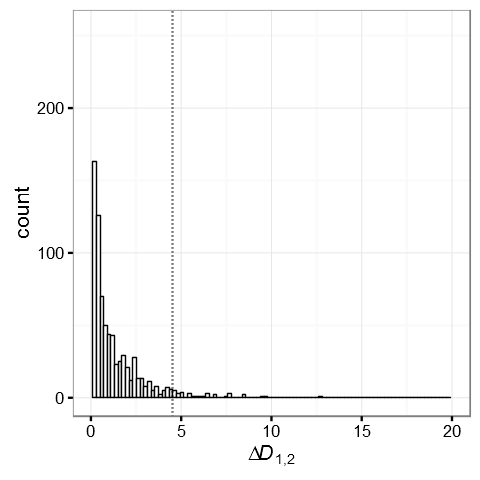

In [18]:
data.frame(x = dd12) %>>% 
    ggplot(aes(x = x)) + 
    geom_histogram(bins = 100, colour = "black", fill = "white", size = 0.3) + 
    scale_x_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) + 
    theme_bw() + 
    geom_vline(xintercept = 4.5, size = 0.5, linetype = "dotted") + 
    xlab(expression(Delta~italic(D)[`1,2`]))

$10^4$回

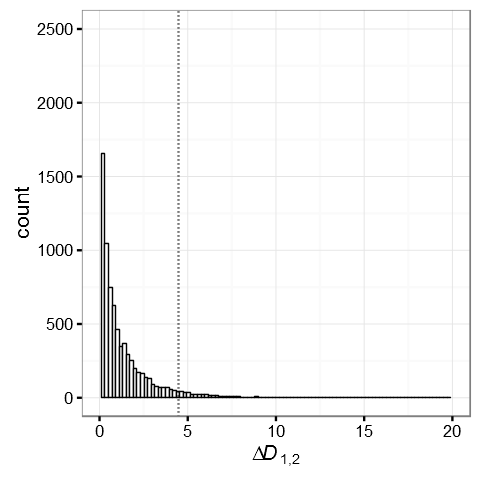

In [33]:
data.frame(x = dd12.x) %>>% 
    ggplot(aes(x = x)) + 
    geom_histogram(bins = 100, colour = "black", fill = "white", size = 0.3) + 
    scale_x_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) + 
    theme_bw() + 
    geom_vline(xintercept = 4.5, size = 0.5, linetype = "dotted") + 
    xlab(expression(Delta~italic(D)[`1,2`]))

$\Delta D_{1,2} \ge 4.5$ となった個数

In [19]:
sum(dd12 >= 4.5)

[1] 33

In [31]:
sum(dd12.x >= 4.5)

[1] 370

In [20]:
as.numeric(c(TRUE, FALSE))

[1] 1 0

$P$ 値は

In [21]:
sum(dd12 >= 4.5) / 1000

[1] 0.033

$P = 0.05$ となる$\Delta D_{1,2}$は

In [22]:
quantile(dd12, 0.95)

95% 
4.027678

$\Delta D_{1,2} = 4.5$ の $P$値は有意水準 0.05 より小さいので，帰無仮説を棄却

`library(boot)` を使うと，

In [23]:
library(boot)

In [24]:
b <- boot(
    d, 
    function(data){
        fit1 <- glm(y ~ 1, data = data, family = poisson)
        fit2 <- glm(y ~ x, data = data, family = poisson)
        fit1$deviance - fit2$deviance
    }, 
    R = 1000, 
    sim = "parametric", 
    ran.gen = function(data, mle){
        out <- data
        out$y <- rpois(nrow(out), lambda = mle)
        out
    }, 
    mle = mean(d$y)
)
b


PARAMETRIC BOOTSTRAP


Call:
boot(data = d, statistic = function(data) {
    fit1 <- glm(y ~ 1, data = data, family = poisson)
    fit2 <- glm(y ~ x, data = data, family = poisson)
    fit1$deviance - fit2$deviance
}, R = 1000, sim = "parametric", ran.gen = function(data, mle) {
    out <- data
    out$y <- rpois(nrow(out), lambda = mle)
    out
}, mle = mean(d$y))


Bootstrap Statistics :
    original    bias    std. error
t1* 4.513941 -3.528679    1.338169

In [25]:
str(b)

List of 10
 $ t0       : num 4.51
 $ t        : num [1:1000, 1] 0.0759 0.1578 0.0459 1.1229 0.9479 ...
 $ R        : num 1000
 $ data     :Classes 'tbl_df', 'tbl' and 'data.frame':	100 obs. of  3 variables:
  ..$ y: int [1:100] 6 6 6 12 10 4 9 9 9 11 ...
  ..$ x: num [1:100] 8.31 9.44 9.5 9.07 10.16 ...
  ..$ f: chr [1:100] "C" "C" "C" "C" ...
  ..- attr(*, "spec")=List of 2
  .. ..$ cols   :List of 3
  .. .. ..$ y: list()
  .. .. .. ..- attr(*, "class")= chr [1:2] "collector_integer" "collector"
  .. .. ..$ x: list()
  .. .. .. ..- attr(*, "class")= chr [1:2] "collector_double" "collector"
  .. .. ..$ f: list()
  .. .. .. ..- attr(*, "class")= chr [1:2] "collector_character" "collector"
  .. ..$ default: list()
  .. .. ..- attr(*, "class")= chr [1:2] "collector_guess" "collector"
  .. ..- attr(*, "class")= chr "col_spec"
 $ seed     : int [1:626] 403 160 -1055776282 1338781385 793776761 -288777907 -486414434 -872170404 1450794148 796870403 ...
 $ statistic:function (data)  
  ..- attr

In [26]:
summary(b$t[,1])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000001  0.091310  0.493500  0.985300  1.348000 11.150000 

In [27]:
sum(b$t >= 4.5)

[1] 31

In [28]:
sum(b$t >= 4.5) / 1000

[1] 0.031

In [29]:
quantile(b$t, 0.95)

95% 
3.600384

### 5.4.2 方法（2）$\chi^2$分布を使った近似計算法

$\Delta D_{1,2}$ の確率分布は自由度1の$\chi^2$分布で近似できる場合がある

* サンプルサイズが大きい場合に有効な近似計算

In [32]:
anova(fit.null, fit.x, test = "Chisq") %>>% print()

Analysis of Deviance Table

Model 1: y ~ 1
Model 2: y ~ x
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)  
1        99     89.507                       
2        98     84.993  1   4.5139  0.03362 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


$P = 0.034$ で帰無仮説は棄却される

## 5.5 「帰無仮説を棄却できない」は「差がない」ではない

## 5.6 検定とモデル選択，そして推定された統計モデルの解釈

## 5.7 まとめ
* 尤度比検定: 逸脱度の差を調べる
* Neyman-Pearson のわくぐみ
    * Type I error に注目
        * 検出力（1 - Type II error の確率）を話題にすることもある
    * 有意水準の決め方に根拠はない
    * 帰無仮説が棄却できない場合は何も言えない
* 検定やモデル選択の結果だけでなく，推定されたモデルが現象をどのように予測するのかも確認すべき

In [34]:
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.1 (2016-06-21)
 system   x86_64, mingw32             
 ui       RTerm                       
 language en                          
 collate  Japanese_Japan.932          
 tz       Asia/Tokyo                  
 date     2016-10-24                  

 package    * version date       source                            
 assertthat   0.1     2013-12-06 CRAN (R 3.2.1)                    
 boot       * 1.3-18  2016-02-23 CRAN (R 3.3.1)                    
 Cairo        1.5-9   2015-09-26 CRAN (R 3.2.2)                    
 colorspace   1.2-6   2015-03-11 CRAN (R 3.2.1)                    
 crayon       1.3.2   2016-06-28 CRAN (R 3.3.1)                    
 DBI          0.5-1   2016-09-10 CRAN (R 3.2.5)                    
 devtools     1.12.0  2016-06-24 CRAN (R 3.3.1)                    
 digest       0.6.10  2016-08-02 CRAN (R 3.3.1)                    
 dplyr      * 0.5.0   2016-06-24 CRAN (R 3.2.5)                    
 evalua